<a href="https://colab.research.google.com/github/ilyunjung/CyberSecurityCapstoneDesign/blob/main/JSMA_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Jacobian Based Saliency Map Attack**

JSMA방법은 뉴럴네트워크에서 입력과 결과값에 대한 맵
핑을 통하여 적대적 사례를 생성하는 방법

데이터 셋의 입력 값에서
특정 부분을 변형하였을 때 출력의 변동을 매핑
(mapping)으로 구성할 수 있는데, 각 히든 레이어
의 출력을 다음 히든 레이어의 입력으로 사용하는 것
을 매핑하여 최종 출력 값이 정답과 달라지도록 변형
시키는 것이다

입력데
이터를 미분하고 이에 대한 값을 saliency map에 맵핑
한 후에 최대한 잘못 오인식 되는 방향으로 노이즈를
추가하여 적대적 사례를 생성하는 방법

## 모델 학습 단계
tensorflow v1을 사용하였기에 
tf.disable_v2_behavior() 명령어를 통해 v1이 실행될 수 있도록 함.

**v1에서 사용되는 변수 및 함수**


logit : [0,1] 범위인 확률을 [−∞,∞]범위로 넓히는 로짓의 특성으로 확률화되지 않은 예측 결과를 말함

placeholder : 처음에 변수를 선언할 때 값을 바로 주는 것이 아니라, 나중에 값을 던져주는 공간을 만들어주는 것

Session : 일종의 실행창으로 내용물과 연산결과를 확인하고 싶을 때 사용용

초기 모델 설정

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

class CNNet(object):
  
  def __init__(self, learning_rate=0.001, input_dim = 28, num_class=10):
    
    #하이퍼 파라미터 인스턴스 변수 생성
    self.learning_rate = learning_rate
    self.num_class = num_class
    self.input_dim = input_dim
 
    self.initializer = tf.keras.initializers.glorot_uniform()
    self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
    
    # 텐서플로우를 위한 랜덤 시드 고정
    self.random_seed = 42
    tf.set_random_seed(self.random_seed)


  def network(self, X, activations=False):
    
    with tf.variable_scope('network', initializer=self.initializer):
      
        # 각 레이어 정의
        self.layers = [
            
            tf.layers.Conv2D(filters=16, kernel_size=3,
                                     strides=(1, 1), activation='relu',padding='SAME'),
            
            tf.layers.Conv2D(filters=32, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.num_class)
        ]
        
        activations_list = []
        
        
        # 전달 경로 루프, 중간 활성화 저장.
        out = X
        for layer in self.layers:
          out = layer(out)
          activations_list.append(out)
        
        if activations:
          return out, activations_list
        else:
          return out, tf.nn.softmax(out)

  def model(self, X, y):

    # 네트워크로부터 로짓을 얻는 과정
    out_logits, _ = self.network(X)
   
    # Cross Entropy 손실 계산
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=y, logits=out_logits))
    
    grads = self.optimizer.compute_gradients(loss)
    
    vars_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                  scope="network")
    grad_list = [(g, v) for g, v in grads if v in vars_list]
    optimize_op = self.optimizer.apply_gradients(grad_list)
    
    return loss, optimize_op, out_logits
  
  def metrics(self, y, logits, verbose=True):
    
    # 예측 값을 가져오고 flatten하는 과정
    y = np.argmax(y, axis=1).flatten()
    y_ = np.argmax(logits, axis=1).flatten()

    confusion = confusion_matrix(y_true=y, y_pred=y_)
    accuracy = accuracy_score(y_true=y, y_pred=y_)
    
    if verbose:
      print ("accuracy score: ", accuracy) 
      
    return accuracy
  
  def train(self, train_X, train_y, test_X, test_y, 
            batch_size=256, epochs=100):
    
    # 전역 그래프 정의를 재설정
    tf.reset_default_graph()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    # placeholder 공간 생성
    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    y = tf.placeholder(shape=[None, self.num_class], dtype=tf.float32)
    
    # optimizer 가져옴
    loss, optimize, out_logits = self.model(X, y)
     
    self.saver = tf.train.Saver()
    
    # session 시작
    with tf.Session(config=config) as sess:
      
      # 변수 초기화
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
      
      # Stochastic Gradient Descent 루프
      for step in range(epochs):
        
        num_train_batches, start = int(train_X.shape[0]/batch_size), 0

        for _ in range(num_train_batches):

            end = start + batch_size         
            limit = end if end < train_X.shape[0] else train_X.shape[0]
            idx = np.arange(start, limit)
            
            # 최적화
            _, step_loss = sess.run([optimize, loss], 
                                    {X: train_X[idx], y: train_y[idx]})
            start = end
        
        print('='*80+'\nEpoch: {0} Training Loss: {1}'.format(step, step_loss))
        
        probs = sess.run(tf.nn.softmax(out_logits), {X: test_X, y: test_y})
        acc = self.metrics(test_y, probs)
        
        self.saver.save(sess, "model.ckpt")
        
      probs = sess.run(out_logits, {X: train_X})
      np.save('representations.npy', probs)
      
      return step_loss, acc

  def predict(self, X_test, logits=False, reps=False):
    
    tf.reset_default_graph()
    tf.set_random_seed(42)

    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    
    # 모델에서 실행중인 inference에 대한 작업을 가져옴
    out_logits, out_probs = self.network(X)
    
    saver = tf.train.Saver()
    # 그래프를 위한 세션 시작
    with tf.Session() as sess:
      
        # 훈련된 모델을 세션에 로드하여 inference 실행
        saver.restore(sess, "model.ckpt")
        # Get 
        rep_logits, probs = sess.run([out_logits, out_probs], {X: X_test})
    
    preds = np.argmax(probs, axis=1).flatten()
    if logits:
      return preds, probs
    elif reps:
      return preds, rep_logits
    else:
      return preds

Instructions for updating:
non-resource variables are not supported in the long term


모델 학습

In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 4차원으로 모양을 바꾸고 intensity를 [0,1]로 가져옴
x_train, x_test = x_train.reshape(-1,28,28,1)/255., x_test.reshape(-1,28,28,1)/255.

# 레이블을을 one hot encoding vector로 변환
y_train_oh, y_test_oh = to_categorical(y_train), to_categorical(y_test)

# 15 epoch만큼 모델 학습
mnist_classifier = CNNet()
mnist_classifier.train(x_train, y_train_oh, x_test, y_test_oh, epochs=15)

Epoch: 0 Training Loss: 0.28667253255844116
accuracy score:  0.9638
Epoch: 1 Training Loss: 0.2531091868877411
accuracy score:  0.9762
Epoch: 2 Training Loss: 0.18849827349185944
accuracy score:  0.9794
Epoch: 3 Training Loss: 0.15626296401023865
accuracy score:  0.982
Epoch: 4 Training Loss: 0.1257825493812561
accuracy score:  0.9825
Epoch: 5 Training Loss: 0.10408517718315125
accuracy score:  0.9834
Epoch: 6 Training Loss: 0.08684990555047989
accuracy score:  0.9835
Epoch: 7 Training Loss: 0.06486759334802628
accuracy score:  0.9836
Epoch: 8 Training Loss: 0.048349760472774506
accuracy score:  0.9834
Epoch: 9 Training Loss: 0.04115532338619232
accuracy score:  0.9836
Epoch: 10 Training Loss: 0.037469398230314255
accuracy score:  0.983
Epoch: 11 Training Loss: 0.02926367148756981
accuracy score:  0.9843
Epoch: 12 Training Loss: 0.0356442891061306
accuracy score:  0.9852
Epoch: 13 Training Loss: 0.028948156163096428
accuracy score:  0.9858
Epoch: 14 Training Loss: 0.010095260106027126


(0.01009526, 0.9846)

In [11]:
# 샘플 10개를 선택
mnist = x_train[np.where(y_train)][:10]
orig_preds, orig_logits = mnist_classifier.predict(mnist, logits = True)
orig_probs = np.max(orig_logits, axis=1).tolist()

saliency_map 
이미지의 픽셀 값에 급격한 변화가 있는 부분을 경사 하강법을 통해 찾아냄

In [12]:
def saliency_map(X, dtdx, dodx, eps, cmin, cmax):
  # 초기 상태를 확인
  c1 = tf.logical_or(eps < 0, X < cmax)
  c2 = tf.logical_or(eps > 0, X > cmin)
  
  # 돌출 맵 조건을 확인
  c3 = dtdx >= 0
  c4 = dodx <= 0
  
  # 1차원 값을 얻어옴
  cond = tf.cast(tf.reduce_all([c1, c2, c3, c4], axis=0),dtype=tf.float32)
  
  score = cond * (dtdx * tf.abs(dodx))
  
  # 각 픽셀에 값을 돌려줌
  score = tf.reshape(score, shape=[1, 784])
  
  return score

jacobian_matrix 정의

벡터와 벡터간 연산에서 각 변수의 미분값으로 구성된 행렬

In [13]:
def jacobian_matrix(y, x, n_class):

  for i in range(n_class):
      if i==0:
          j = tf.gradients(y[i], x)
      else:
          j = tf.concat([j, tf.gradients(y[i], x)],axis=0)
  return j

적대적 이미지를 생성하기 위한 JSMA 구현 정의

In [14]:
def jsma(X_adv, target_y, model, eps, cmin=0.0, cmax=1.0):

  # 입력에 대한 모형 로짓 및 확률을 가져옴
  logits, probs = model(tf.reshape(X_adv, shape=(-1,28,28,1)))
  
  # 입력에 대한 예측을 가져옴
  y_ind = tf.argmax(probs[0])
  
  # 입력할 logits의 jacobian matrix 계산
  jacobian = jacobian_matrix(tf.reshape(logits, (-1,)), X_adv, 10)

  # 예측 및 목표값에 기록된 logits의의 기울기를 가져옴
  grad_input, grad_target = jacobian[y_ind], jacobian[target_y]
  grad_other = grad_input - grad_target
  
  # 각 차원에 대한 중요도 점수를 계산
  score = saliency_map(X_adv, grad_target, grad_other, eps, cmin, cmax)

  # 입력 차원을 선택하고 엡실론 값을 적용
  idx = tf.argmax(score, axis=1)
  pert = tf.one_hot(idx, 784, on_value=eps, off_value=0.0)
  pert = tf.reshape(pert, shape=tf.shape(X_adv))

  X_adv = tf.clip_by_value(X_adv + pert, cmin, cmax)

  return X_adv, pert

In [15]:
# 입력 이미지에서 epoch 횟수만큼 JSMA를 실행
def generate_jsma(model, X, target, eps=1.0, epochs=50):

  tf.reset_default_graph()
  tf.set_random_seed(42)
  
  X_p = tf.placeholder(shape=[28, 28, 1], dtype=tf.float32)
  
  # jsma의 반복 한번에 대한 op
  adv_op = jsma(X_p, target_y=target, model=model, eps=eps)

  digit = X.reshape(28,28,1)

  with tf.Session() as sess:
    tf.train.Saver().restore(sess, "model.ckpt")
    for i in range(epochs):
      
      digit, pert_iter = sess.run(adv_op, {X_p: digit})
      
  pert = digit - X
      
  return digit.reshape(28,28), pert.reshape(28,28)

In [16]:
# 원래 입력, perturbation 및 적대적 입력을 시각화하는 함수
# perturbation : 감지하기 힘든 작은 노이즈
def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):

  fig, axes = plt.subplots(ncols=3, nrows=10, figsize=(18,18))

  for i in range(10):

      confidence = str(round(orig_probs[i],2))
      pixels = origs[i].reshape((28, 28))
      axes[i][0].imshow(pixels, cmap='gray')
      axes[i][0].set_axis_off()
      title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][0].set_title(title.format(orig_preds[i], confidence))

      pixels = perturbs[i].reshape((28, 28))
      axes[i][1].imshow(pixels, cmap='gray')
      axes[i][1].set_axis_off()
      title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
      axes[i][1].set_title(title.format(eps))

      confidence = str(round(adv_probs[i],2))
      pixels = advs[i].reshape((28, 28))
      axes[i][2].imshow(pixels, cmap='gray')
      axes[i][2].set_axis_off()
      title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
      axes[i][2].set_title(title.format(
          adv_preds[i], confidence))

  plt.subplots_adjust(wspace=0.1, hspace=0.9)
  fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
  plt.show()

JSMA 방법을 사용하여 적대적 이미지와 섭동 생성

In [17]:
advs_jsma, perts_jsma = [], []
for imgs in mnist:
  digit,pert = generate_jsma(mnist_classifier.network,
                        imgs,
                        target=6,
                        eps=0.5,
                        epochs=100)
  advs_jsma.append(digit)
  perts_jsma.append(pert)

# 적대적 예제 생성을 위한 predictions and confidence 가져옴
preds_jsma, probs_jsma = mnist_classifier.predict(
    np.array(advs_jsma).reshape(10,28,28,1), logits=True)

# 예측 및 확률을 리스트로 변환 
preds_jsma = preds_jsma.tolist()
probs_jsma = np.max(probs_jsma, axis=1).tolist()


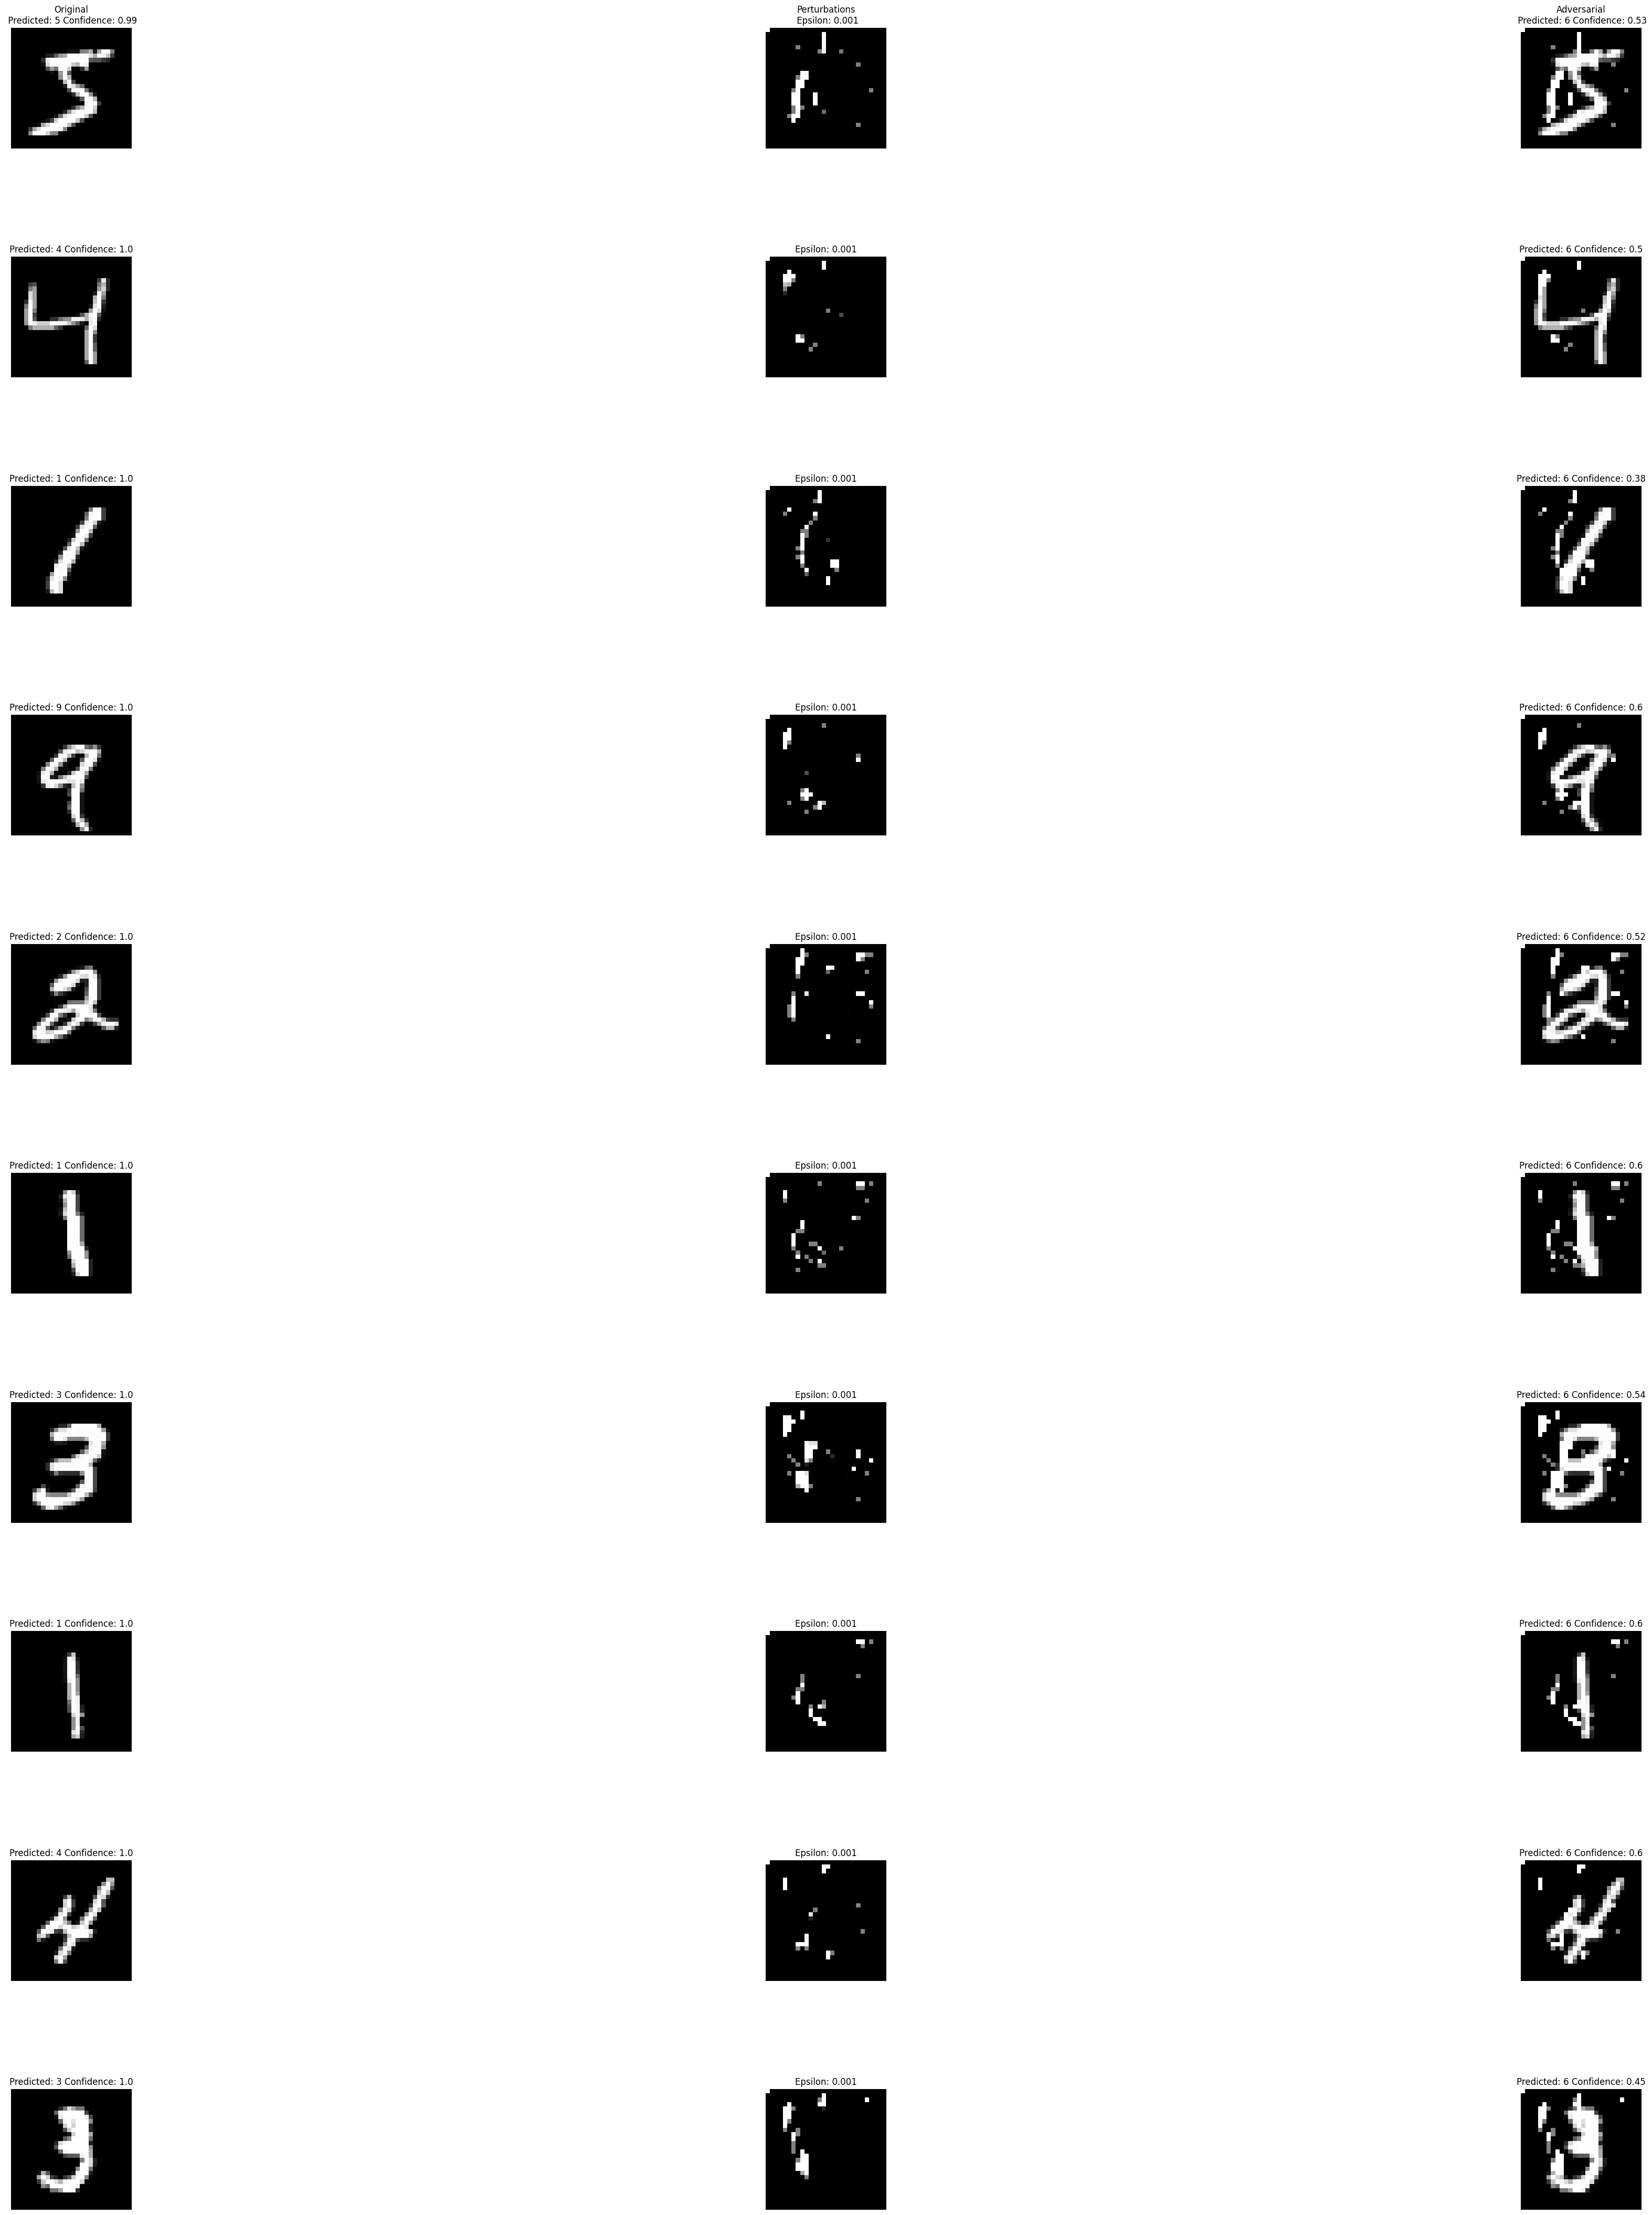

In [18]:
# 결과 그래프
plot_adversarials(mnist, np.array(perts_jsma), np.array(advs_jsma), 
                  orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.001)

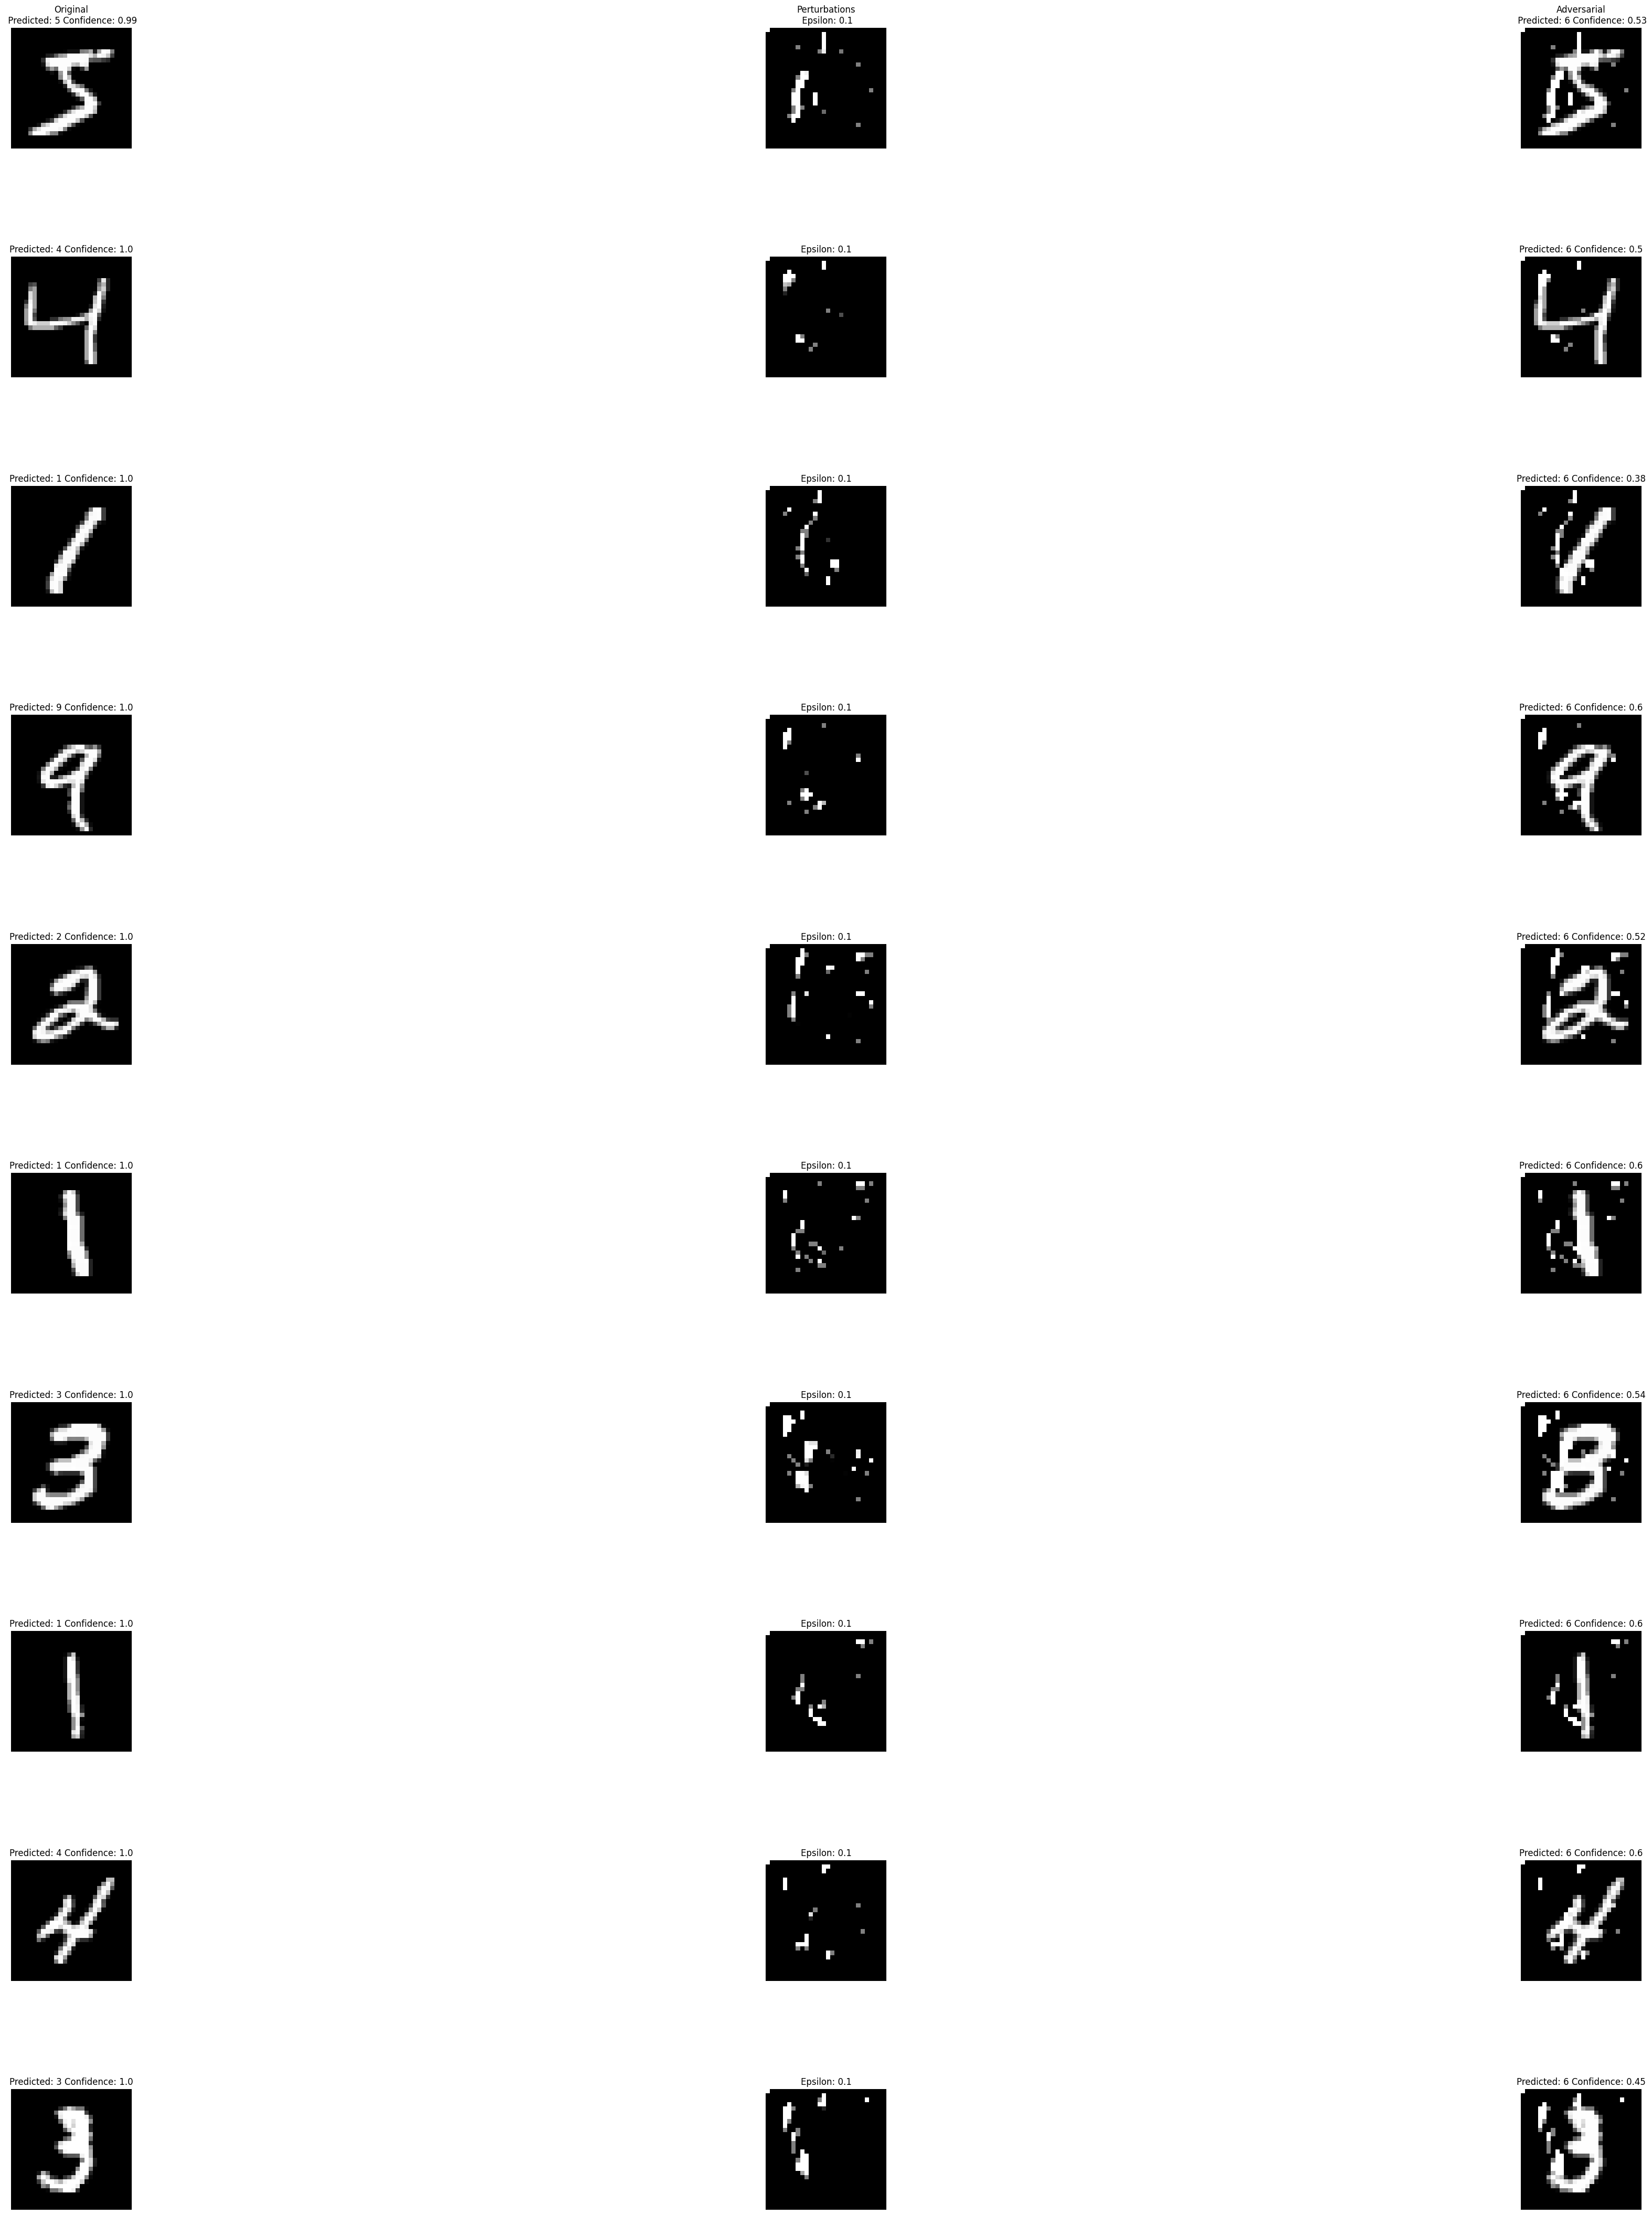

In [19]:
# 결과 그래프
plot_adversarials(mnist, np.array(perts_jsma), np.array(advs_jsma), 
                  orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.1)

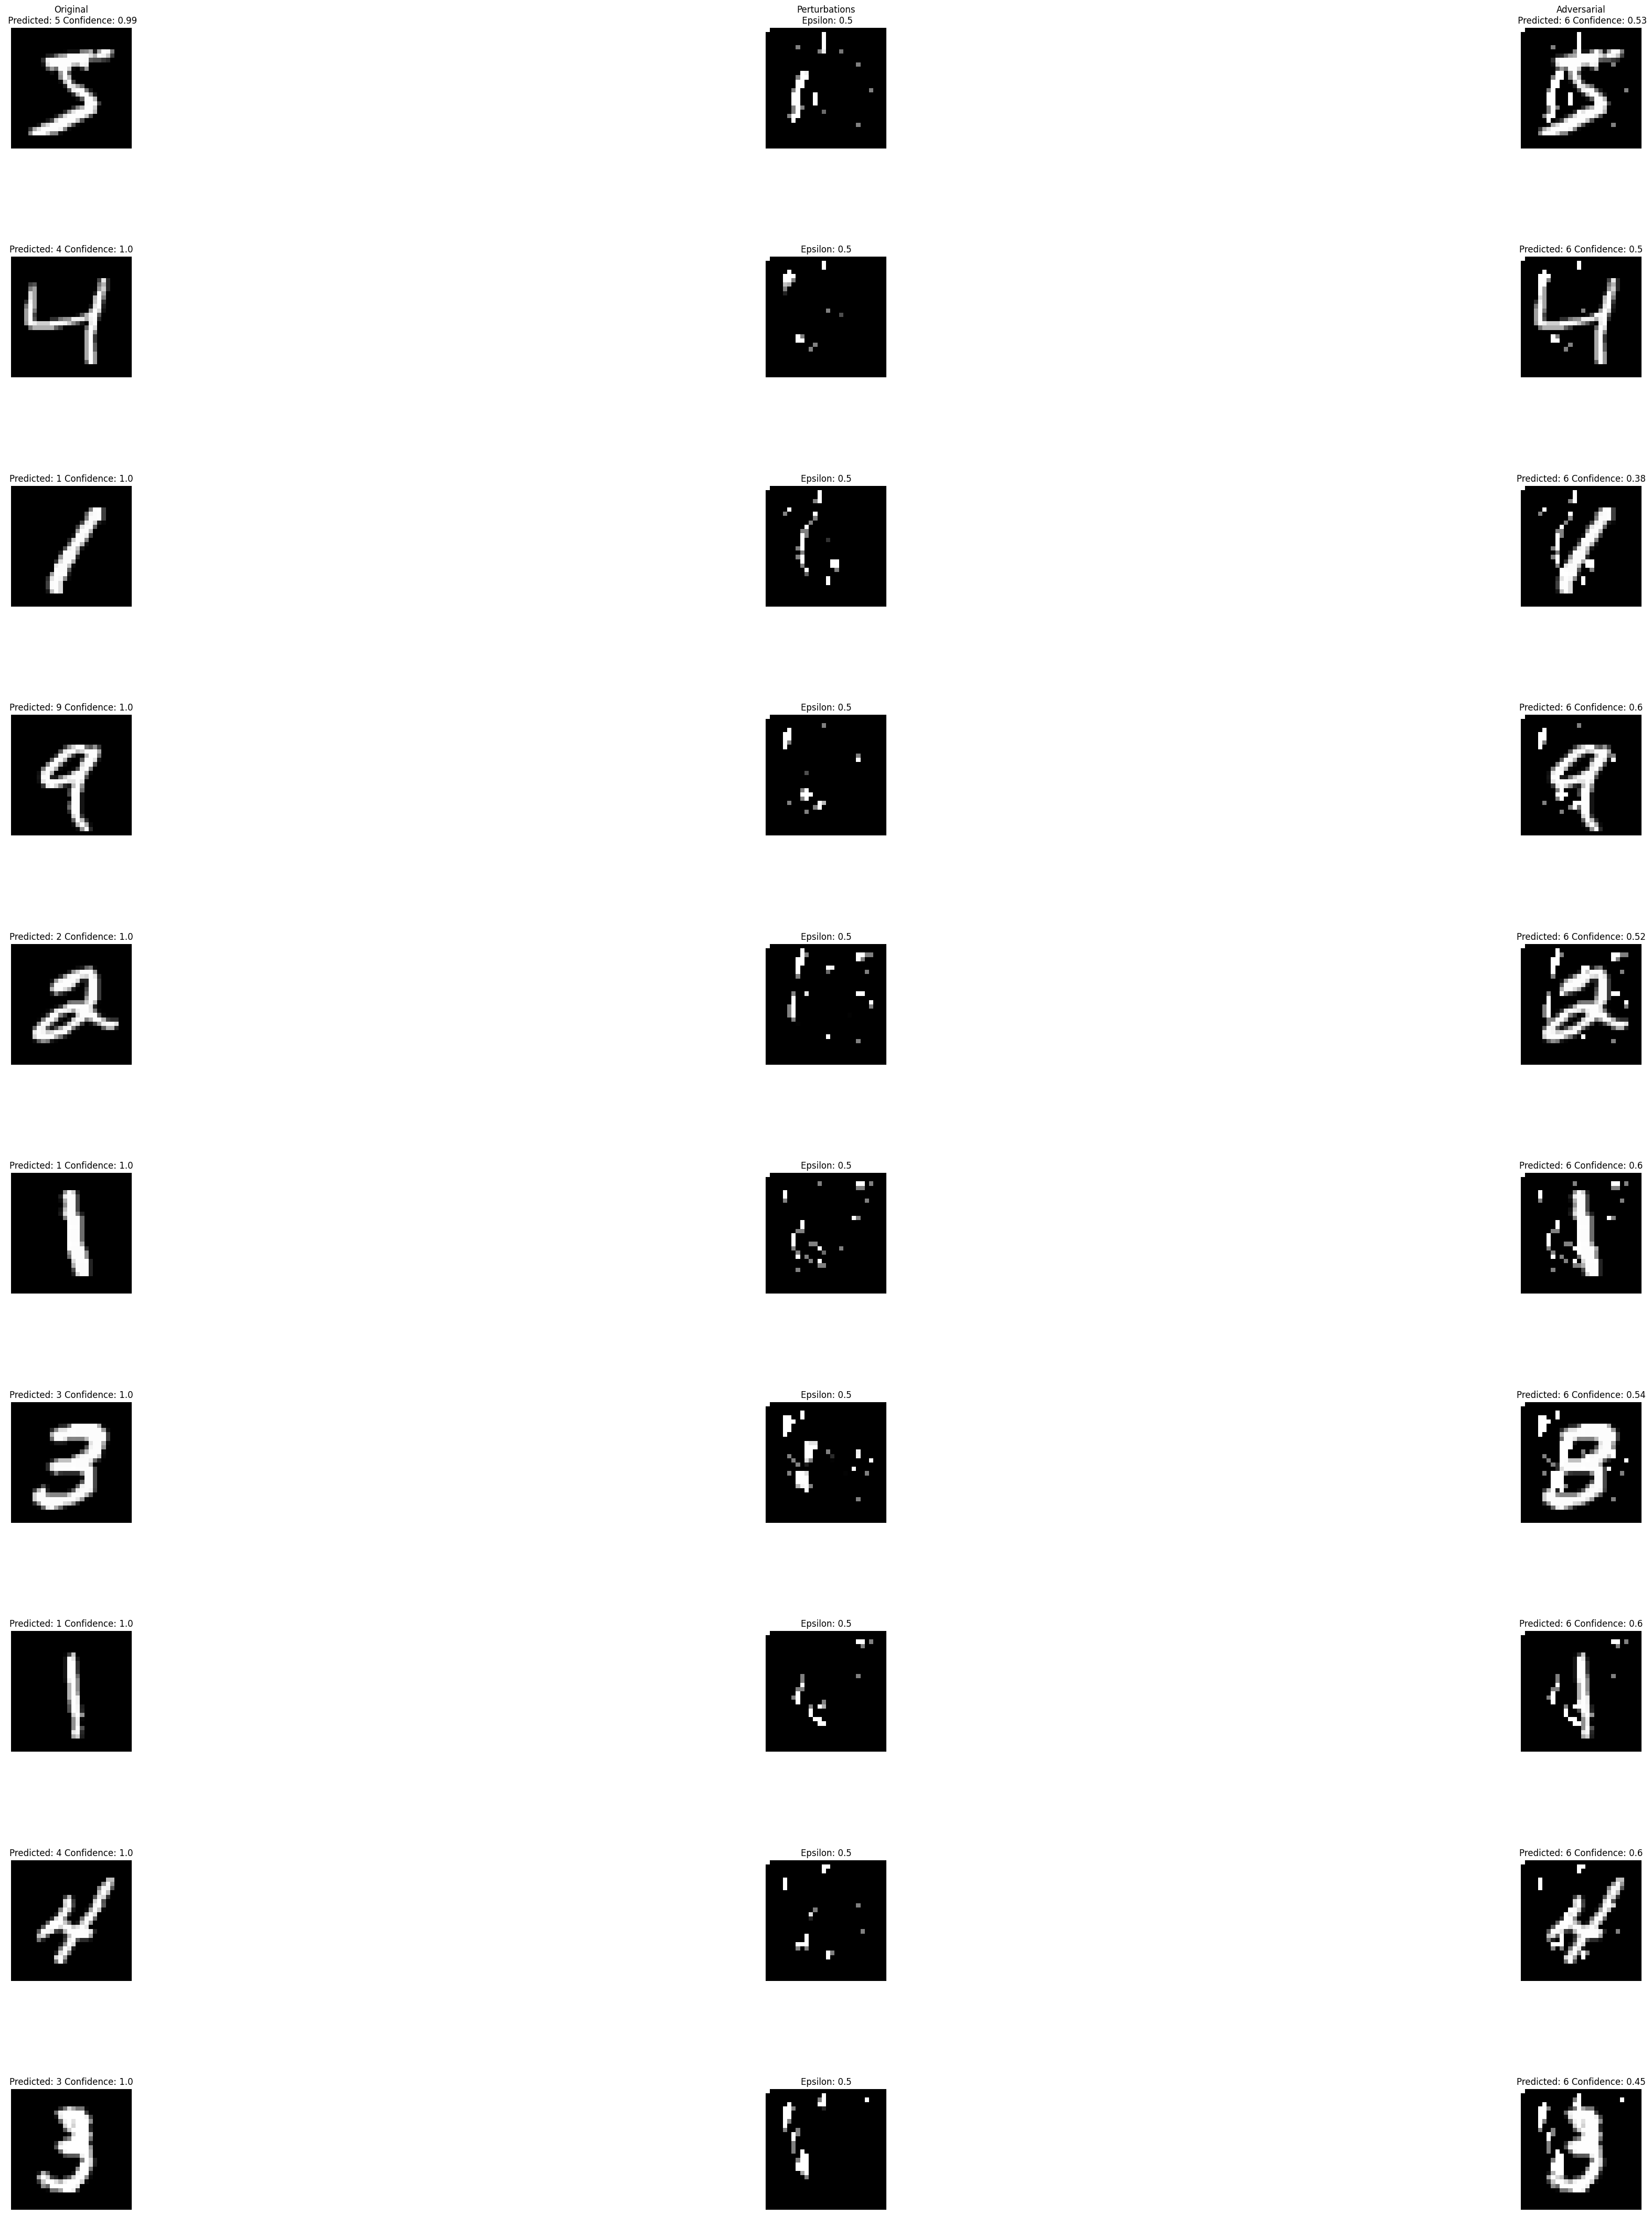

In [20]:
# 결과 그래프
plot_adversarials(mnist, np.array(perts_jsma), np.array(advs_jsma), 
                  orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.5)